# Prepare the Colab Notebook


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%ls

drive/  sample_data/


In [3]:
%cd drive/My Drive/Papers and Stuff/detectron2

/content/drive/My Drive/Papers and Stuff/detectron2


# Install the dependencies
A one-time thing for a personal computer but in colab you gotta install it every time

In [8]:
# install dependencies:
# (use +cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Requirement already up-to-date: torch==1.4+cu100 in /usr/local/lib/python3.6/dist-packages (1.4.0+cu100)
Requirement already up-to-date: torchvision==0.5+cu100 in /usr/local/lib/python3.6/dist-packages (0.5.0+cu100)


KeyboardInterrupt: ignored

In [11]:
!pip install -e detectron2_repo

Obtaining file:///content/drive/My%20Drive/Papers%20and%20Stuff/detectron2/detectron2_repo
  Found existing installation: detectron2 0.1
    Can't uninstall 'detectron2'. No files were found to uninstall.
  Running setup.py develop for detectron2


Be careful that you restart the runtime here above. Otherwise the "imports" in the next block will show error:     "  
ModuleNotFoundError: No module named 'detectron2'  "

# Imports
needed even in PC

In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [2]:
%ls

drive/  sample_data/


In [3]:
%cd drive/My Drive/Papers and Stuff/detectron2

/content/drive/My Drive/Papers and Stuff/detectron2


# Preparation for Testing

In [4]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = "./output/model_final.pth"
predictor = DefaultPredictor(cfg)


'roi_heads.box_predictor.cls_score.weight' has shape (15, 1024) in the checkpoint but (81, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (15,) in the checkpoint but (81,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (56, 1024) in the checkpoint but (320, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (56,) in the checkpoint but (320,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (14, 256, 1, 1) in the checkpoint but (80, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (14,) in the checkpoint but (80,) in the model! Skipped.


In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("./train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 600    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("./val", )
predictor = DefaultPredictor(cfg)

In [0]:
name_list = ['buoy_red', 'buoy_green', 'buoy_yellow', 'qual_gate', 'channel', 'bin_cover', 'bin', 'torpedo_target', 'torpedo_hole', 'torpedo_cover', 'object_dropoff', 'object_pickup']

In [0]:
# reading the dataset_dicts
import json
with open('dataset_dicts.json') as json_file:
    dataset_dicts = json.load(json_file)

In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog

d='train'
DatasetCatalog.register("./train", lambda d=d: get_dicts("./" + d))
MetadataCatalog.get("./train").set(thing_classes=name_list)
for d in "val":
    DatasetCatalog.register("./" + d, lambda d=d: get_dicts("./" + d))
    MetadataCatalog.get("./" + d).set(thing_classes=name_list)
train_metadata = MetadataCatalog.get("./train")

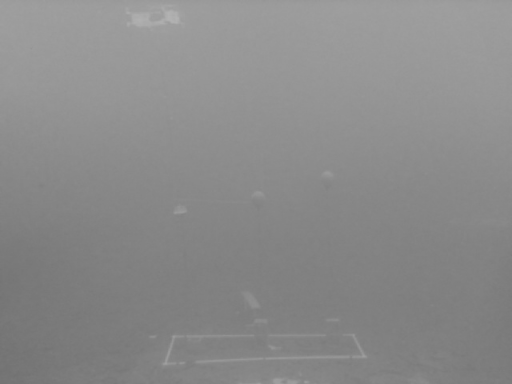

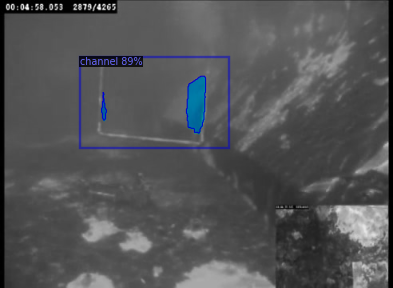

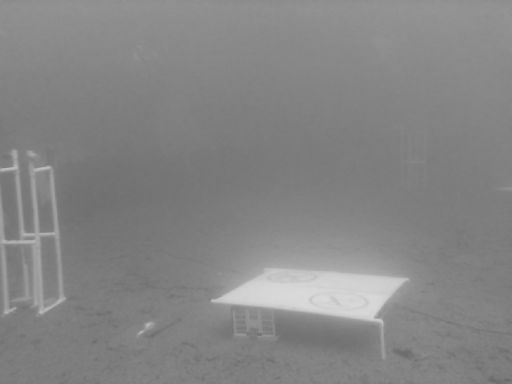

In [10]:
from detectron2.utils.visualizer import ColorMode
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=train_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

# Inference(Testing)!
After all the above code is run, you just have to run the below codes for detecting images(as much as u want)

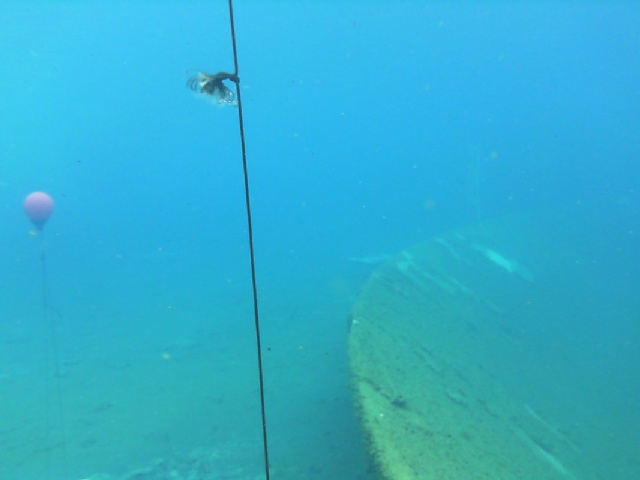

In [11]:
im = cv2.imread('./train/100.jpg')
cv2_imshow(im)

In [0]:
# 'outputs' will contain the bounding boxes and mask

outputs = predictor(im) # this is the actual testing code, so u just have to change the 'im' with any other "im=cv2.imread('your_image.jpg')"

In [13]:
print(outputs)

{'instances': Instances(num_instances=1, image_height=480, image_width=640, fields=[pred_boxes = Boxes(tensor([[ 20.9387, 187.3436,  57.3440, 228.4064]], device='cuda:0')), scores = tensor([0.7711], device='cuda:0'), pred_classes = tensor([0], device='cuda:0'), pred_masks = tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0'), ])}


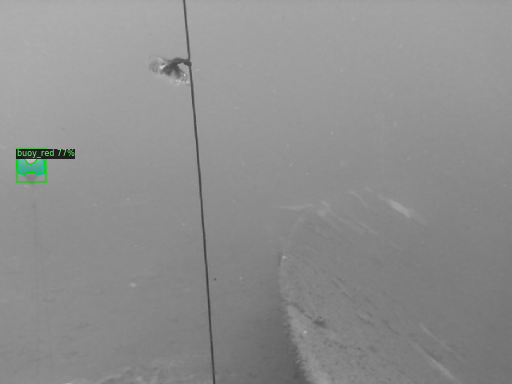

In [15]:
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
              metadata=train_metadata, 
              scale=0.8, 
              instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [0]:
import cv2

image_collection = []
vidcap = cv2.VideoCapture('video.mp4')
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        outputs = predictor(image)
        v = Visualizer(image[:, :, ::-1],
                      metadata=train_metadata, 
                      scale=0.8, 
                      instance_mode=ColorMode   # remove the colors of unsegmented pixels
        )
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        image_collection.append(v.get_image()[:, :, ::-1])
    return hasFrames
sec = 0
frameRate = 0.25 #//it will capture image in each 0.5 second
count=1
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

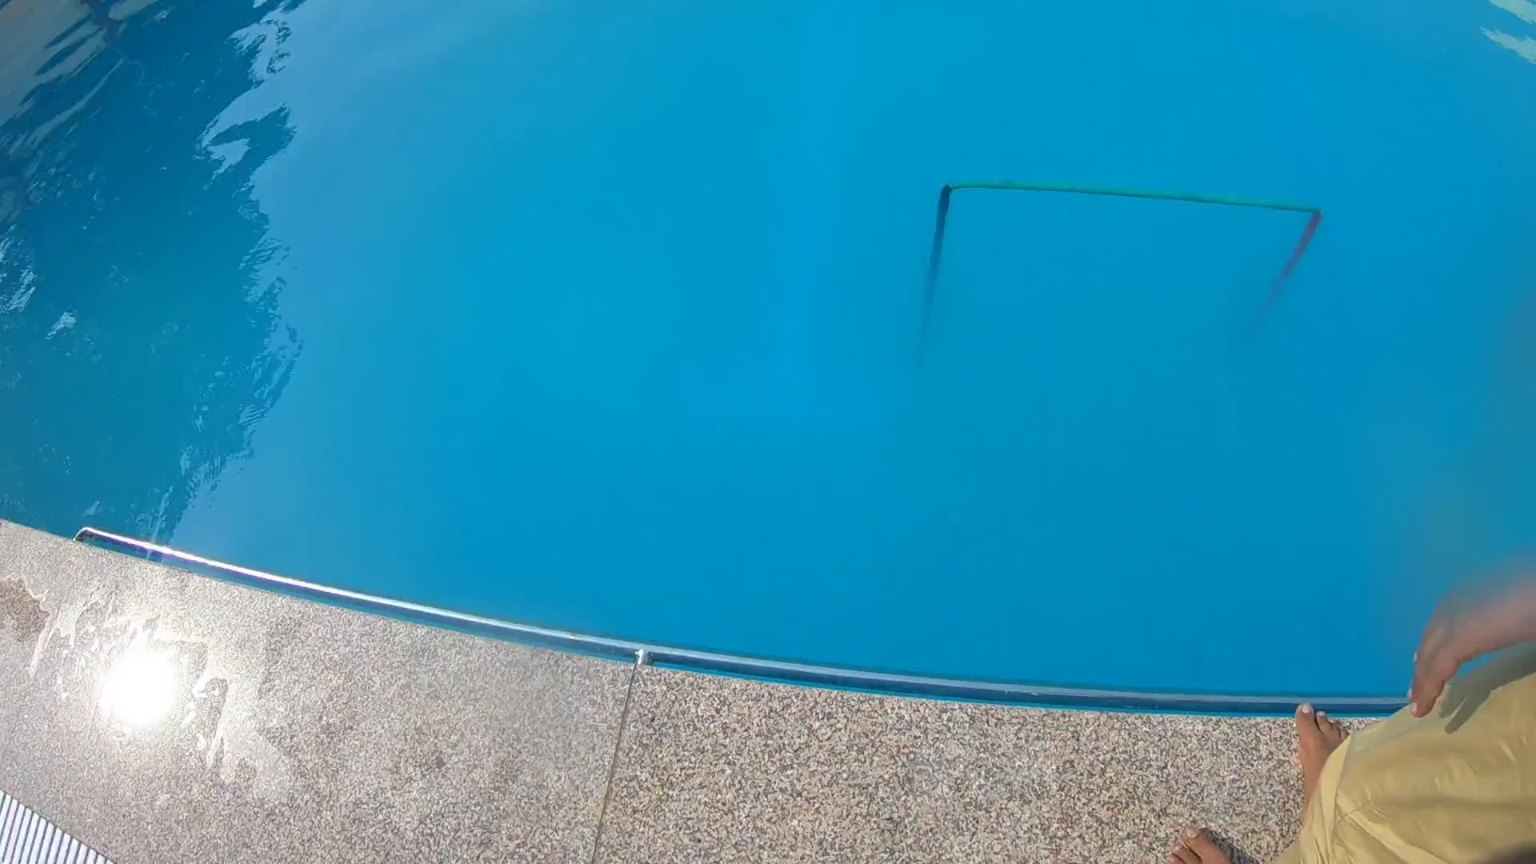

In [32]:
cv2_imshow(image_collection[0])

In [0]:
import cv2
import numpy as np
import os
from os.path import isfile, join

pathOut = 'video_out_color.avi'
fps = 4
frame_array = []

for i in range(len(image_collection)):
    #reading each files
    img = image_collection[i]
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()